In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.mixed_precision import LossScaleOptimizer
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import random
import os
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
IMAGE_SIZE = [224, 224]

In [5]:
VGG19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [6]:
VGG19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
for layer in VGG19.layers:
    layer.trainable = False

In [8]:
# folders = glob('/Users/rutujajadhav/Desktop/r/Dataset/Train/*')
folders = glob('/content/drive/MyDrive/Malaria-Detection/Dataset/Train/*')
folders

['/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Uninfected',
 '/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Parasite']

In [9]:
# PARA_DIR = "/Users/rutujajadhav/Desktop/r/Dataset/Train/Parasite/"
PARA_DIR = '/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Parasite/'

# UNIF_DIR =  "/Users/rutujajadhav/Desktop/r/Dataset/Train/Uninfected/"
UNIF_DIR = '/content/drive/MyDrive/Malaria-Detection/Dataset/Train/Uninfected/'


In [10]:
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(UNIF_DIR)

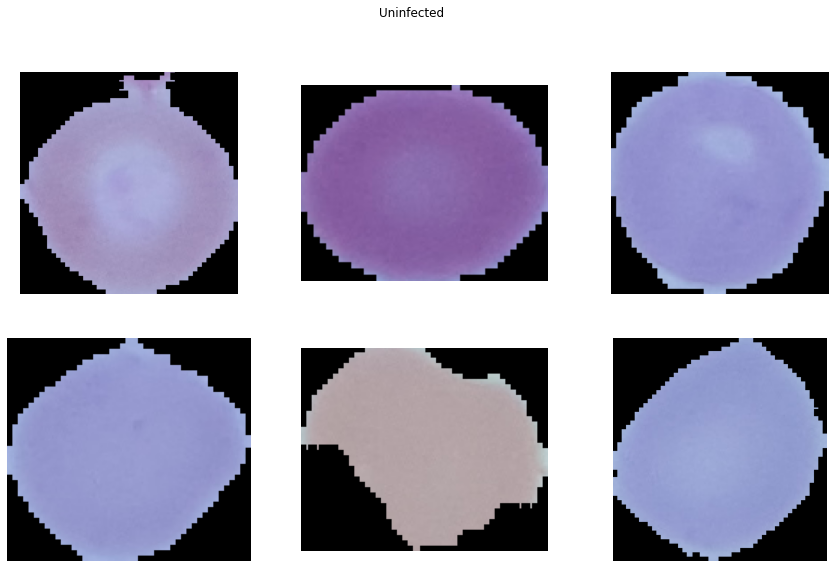

In [11]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(UNIF_DIR+''+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Uninfected')
plt.show()

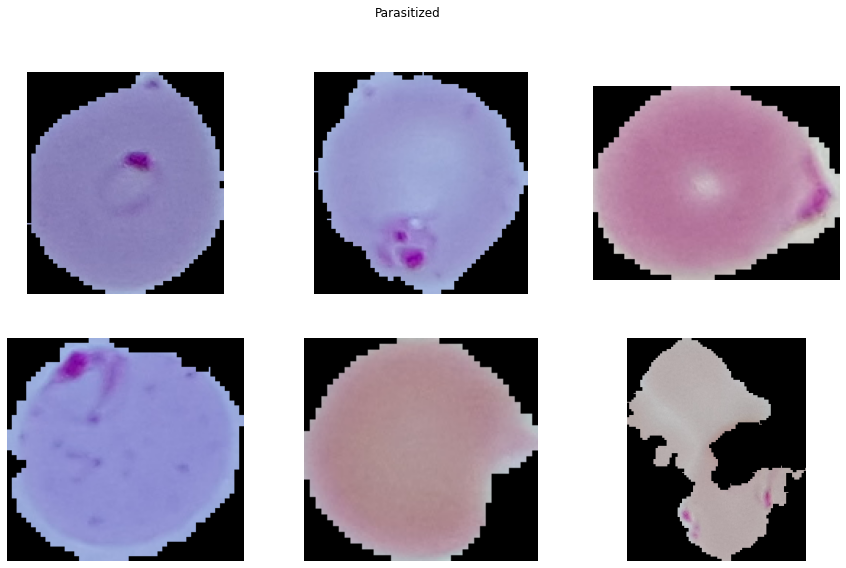

In [12]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(PARA_DIR+''+sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasitized')
plt.show()

In [13]:
x=Flatten()(VGG19.output)

In [14]:
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=VGG19.input, outputs=prediction)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
opt3 = Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad",
)
opt3 = LossScaleOptimizer(opt3)


In [17]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt3,
  metrics=['accuracy']
)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  validation_split=0.2) # set validation split


test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                subset='training') # set as training data

Found 22058 images belonging to 2 classes.


In [20]:
validation_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                subset='validation') # set as validation data

Found 5513 images belonging to 2 classes.


In [21]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset/Test/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [22]:
r = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=40,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set),
  workers=20
)

Epoch 1/30
690/690 [==============================] - 634s 873ms/step - loss: 0.4963 - accuracy: 0.7713 - val_loss: 0.4496 - val_accuracy: 0.8172
Epoch 2/30
690/690 [==============================] - 356s 513ms/step - loss: 0.3995 - accuracy: 0.8346 - val_loss: 0.4162 - val_accuracy: 0.8373
Epoch 3/30
690/690 [==============================] - 357s 506ms/step - loss: 0.3680 - accuracy: 0.8509 - val_loss: 0.3886 - val_accuracy: 0.8504
Epoch 4/30
690/690 [==============================] - 360s 512ms/step - loss: 0.3479 - accuracy: 0.8616 - val_loss: 0.3710 - val_accuracy: 0.8476
Epoch 5/30
690/690 [==============================] - 362s 519ms/step - loss: 0.3360 - accuracy: 0.8687 - val_loss: 0.3609 - val_accuracy: 0.8618
Epoch 6/30
690/690 [==============================] - 362s 514ms/step - loss: 0.3242 - accuracy: 0.8751 - val_loss: 0.3511 - val_accuracy: 0.8600
Epoch 7/30
690/690 [==============================] - 370s 524ms/step - loss: 0.3175 - accuracy: 0.8757 - val_loss: 0.3476 -

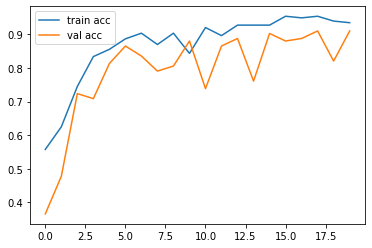

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

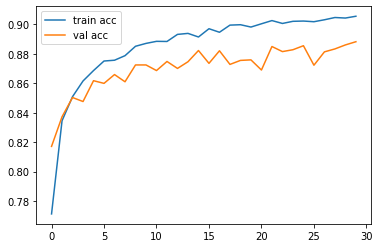

In [23]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('model2_vgg19.h5')

In [ ]:
y_pred = model.predict(test_set)

In [ ]:
y_pred

array([[9.9819463e-01, 1.8054114e-03],
       [9.9945599e-01, 5.4407300e-04],
       [9.9471539e-01, 5.2845511e-03],
       [5.5716217e-01, 4.4283780e-01],
       [1.7551520e-01, 8.2448477e-01],
       [1.8165258e-01, 8.1834745e-01],
       [2.5615332e-01, 7.4384671e-01],
       [4.9283889e-01, 5.0716102e-01],
       [2.9270124e-01, 7.0729876e-01],
       [4.6315503e-01, 5.3684497e-01],
       [9.9640012e-01, 3.5998535e-03],
       [1.5682185e-01, 8.4317815e-01],
       [2.6788801e-01, 7.3211199e-01],
       [8.3348185e-01, 1.6651815e-01],
       [9.0849304e-01, 9.1506958e-02],
       [9.9952936e-01, 4.7067297e-04],
       [9.4206548e-01, 5.7934463e-02],
       [9.2250752e-01, 7.7492490e-02],
       [9.9807358e-01, 1.9263531e-03],
       [9.0530747e-01, 9.4692580e-02],
       [9.9999511e-01, 4.8848628e-06],
       [7.7909660e-01, 2.2090338e-01],
       [9.5817727e-01, 4.1822754e-02],
       [4.7147498e-01, 5.2852499e-01],
       [6.4079052e-01, 3.5920948e-01],
       [4.2662790e-01, 5.

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1])

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model2_vgg19.h5')

In [ ]:
img=image.load_img('/Users/rutujajadhav/Desktop/r/Dataset/Test/Uninfected/2.png',target_size=(224,224))

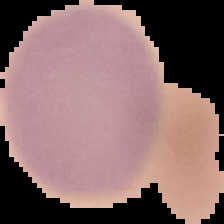

In [ ]:
img

In [ ]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [ ]:
x.shape

(224, 224, 3)

In [ ]:
x=x/255

In [ ]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [ ]:
model.predict(x)

array([[0.12515293, 0.8748471 ]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(x), axis=1)

In [ ]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")
  

Uninfected
